# Tutorial: Automated Machine Learning
This is the code for the paper entitled "**[IoT Data Analytics in Dynamic Environments: From An Automated Machine Learning Perspective](https://arxiv.org/abs/2209.08018)**" published in *Engineering Applications of Artificial Intelligence* (Elsevier's Journal, IF:7.8).<br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)<br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "IoT Data Analytics in Dynamic Environments: From An Automated Machine Learning Perspective", *Engineering Applications of Artificial Intelligence*, vol. 116, pp. 1-33, 2022, doi: https://doi.org/10.1016/j.engappai.2022.105366.

# Code Part 2: Automated Online Learning (Dynamic Data Stream Analytics)
Online learning: Online learning techniques are able to train models using continuously incoming online data streams in dynamic environments. By learning a single data sample at a time, online learning models can reduce memory requirements for data storage and learn new data patterns. Additionally, online learning models can often achieve real-time processing and address concept drift issues. Thus, when applied to dynamic data streams or when inadequate data is available, online learning is often more effective than batch learning.

## Dataset 2: IoTID20
A subset of the IoT network traffic data randomly sampled from the [IoTID20 dataset](https://sites.google.com/view/iot-network-intrusion-dataset/home).   

IoTID20 dataset was created by using normal and attack virtual machines as network platforms, simulating IoT services with the node-red tool, and extracting features with the Information Security Center of Excellence (ISCX) flow meter program. A typical smart home environment was established for generating this dataset using five IoT devices or services: a smart fridge, a smart thermostat, motion-activated lights, a weather station, and a remotely-activated garage door. Thus, the traffic data samples of normal and abnormal IoT devices are collected in Pcap files.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import time

In [2]:
import warnings 
warnings.filterwarnings('ignore')

## Read the sampled IoTID20 dataset

In [3]:
df = pd.read_csv("Data/IoT_2020_b_0.01.csv")

In [4]:
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Bwd_Pkt_Len_Max,...,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Std,FIN_Flag_Cnt,Pkt_Size_Avg,Init_Bwd_Win_Byts,Idle_Mean,Idle_Max,Idle_Min,Label
0,12708,25886,53190,200,9020,3760,124,0.0,2776.0,1388.0,...,0.00,16129.03,0.00,0,2082.0,1869,124.00,124.0,124.0,1
1,60,25883,60357,110,7760,3649,46189,2528.0,0.0,0.0,...,43.30,43.30,698.97,0,632.0,126,15396.33,40225.0,1910.0,1
2,12695,25883,9020,203,52739,2261,73,1388.0,1388.0,1388.0,...,13698.63,13698.63,0.00,0,2082.0,1869,73.00,73.0,73.0,1
3,12690,25886,52717,200,9020,1963,149,0.0,0.0,0.0,...,13422.82,6711.41,0.00,0,0.0,32679,74.50,75.0,74.0,1
4,12690,25886,52717,200,9020,1905,83,0.0,0.0,0.0,...,12048.19,12048.19,0.00,0,0.0,32422,83.00,83.0,83.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,12659,25886,10125,200,9020,1057,70,0.0,2776.0,1388.0,...,0.00,28571.43,0.00,0,2082.0,1869,70.00,70.0,70.0,1
6248,13708,25883,60158,233,8899,3264,40,128.0,32.0,32.0,...,100000.00,25000.00,0.00,0,38.4,-1,10.00,21.0,5.0,1
6249,7655,15614,8487,200,554,3697,1283,0.0,0.0,0.0,...,0.00,1558.85,0.00,0,0.0,14600,1283.00,1283.0,1283.0,1
6250,62696,25889,64783,233,9988,3192,222,96.0,32.0,32.0,...,13513.51,4504.50,0.00,0,40.0,-1,74.00,206.0,8.0,1


# 1. Automated Data Pre-Processing

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [5]:
# Define the automated data encoding function
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

In [6]:
df=Auto_Encoding(df)

## Automated Imputation
Detect and impute missing values to improve data quality

In [7]:
# Define the automated data imputation function
def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df

In [8]:
df=Auto_Imputation(df)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [9]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index
    
    # check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

In [10]:
df=Auto_Normalization(df)

Statistics=0.108, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


# 2. Automated Feature Engineering
Feature selection method 1: **Information Gain (IG)**, used to remove irrelevant features to improve model efficiency  
Feature selection method 2: **Pearson Correlation**, used to remove redundant features to improve model efficiency and accuracy  

In [11]:
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    features = data.drop(['Label'],axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values
    
    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
#     print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [12]:
# Remove redundant features
def Feature_Redundancy_Pearson(data):
    correlation_threshold=0.90 # Only remove features with the redundancy>90%. It can be changed
    features = data.drop(['Label'],axis=1)
    corr_matrix = features.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
#     print(record_collinear)
    return to_drop

In [13]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns = drop1)
    
    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns = drop2)
    
    return dfh2

In [14]:
dfh2 = Auto_Feature_Engineering(df)
dfh2

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Bwd_Pkts,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Std,Fwd_IAT_Tot,Bwd_IAT_Std,Bwd_Pkts/s,Pkt_Len_Std,Init_Bwd_Win_Byts,Idle_Mean,Label
0,0.198248,0.446464,0.821049,0.413136,0.148302,0.874767,0.001241,0.123680,0.220603,0.006440,0.000000,0.000000,0.0,0.016109,0.000000,0.028534,0.002506,1
1,0.000765,0.446413,0.931680,0.222458,0.127585,0.848929,0.466032,0.000000,0.000539,0.000023,0.336694,0.458352,0.0,0.000023,0.829215,0.001938,0.311194,1
2,0.198045,0.446413,0.139234,0.419492,0.867104,0.525838,0.000726,0.061840,0.374723,0.010947,0.000000,0.000000,0.0,0.013679,0.000000,0.028534,0.001475,1
3,0.197967,0.446464,0.813747,0.413136,0.148302,0.456471,0.001493,0.000000,0.000000,0.008042,0.000011,0.000843,0.0,0.006691,0.000000,0.498657,0.001506,1
4,0.197967,0.446464,0.813747,0.413136,0.148302,0.442970,0.000827,0.000000,0.000000,0.009627,0.000000,0.000000,0.0,0.012028,0.000000,0.494736,0.001678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,0.197483,0.446464,0.156291,0.413136,0.148302,0.245577,0.000696,0.123680,0.390782,0.011417,0.000000,0.000000,0.0,0.028552,0.000000,0.028534,0.001415,1
6248,0.213862,0.446413,0.928608,0.483051,0.146312,0.759311,0.000394,0.001426,0.039416,0.049988,0.000116,0.000216,0.0,0.024980,0.000000,0.000000,0.000202,1
6249,0.119352,0.269300,0.131007,0.413136,0.009109,0.860102,0.012935,0.000000,0.000000,0.000611,0.000000,0.000000,0.0,0.001539,0.000000,0.222794,0.025932,1
6250,0.978750,0.446516,1.000000,0.483051,0.164217,0.742551,0.002230,0.001426,0.005682,0.007195,0.001788,0.000182,0.0,0.004484,0.000000,0.000000,0.001496,1


## Train-test split
Split the dataset into the training and the test set   

Here we used the 0.1%/99.9% split, because for online learning, the initial available data would only be a small percentage, and the incoming data streams will be continously learned by the data analytics models. It can be changed based on specific tasks

In [33]:
X = dfh2.drop(['Label'],axis=1)
y = dfh2['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.001, test_size = 0.999, shuffle=False,random_state = 0)

# 3. Model Learning

Four state-of-the-art online learners: 
* Hoeffding Tree (HT)
* Leveraging Bagging (LB)
* Adaptive Random Forest (ARF) 
* Streaming Random Patches (SRP)


An offline learner for comparison:
* LightGBM


## Static Model learning: LightGBM (for Comparison)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       361
           1       0.94      1.00      0.97      5885

    accuracy                           0.94      6246
   macro avg       0.47      0.50      0.49      6246
weighted avg       0.89      0.94      0.91      6246

Accuracy: 94.22%
Precision: 94.22%
Recall: 100.0%
F1-score: 97.024%


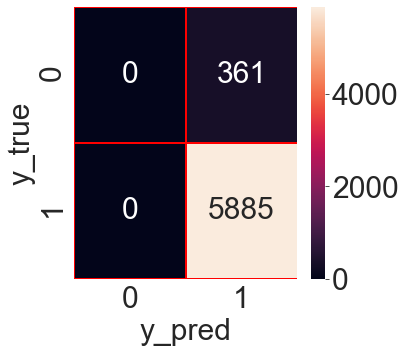

Wall time: 185 ms


In [34]:
%%time
# LightGBM algorithm
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+str(round(accuracy_score(y_test, y_pred),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test, y_pred),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test, y_pred),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test, y_pred),5)*100)+"%")

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

The accuracy of the static LightGBM model is 94.22%, which can be improved by using online learning methods that can adapt to concept drifts.

## Online Learning

In [35]:
# Import the online learning metrics and algorithms from the River library
import river
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, EDDM, ADWIN

In [36]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),5)*100)+"%")
    return t, m

In [50]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 95.757%
Precision: 95.89999999999999%
Recall: 99.762%
F1-score: 97.79299999999999%
Wall time: 1.41 s


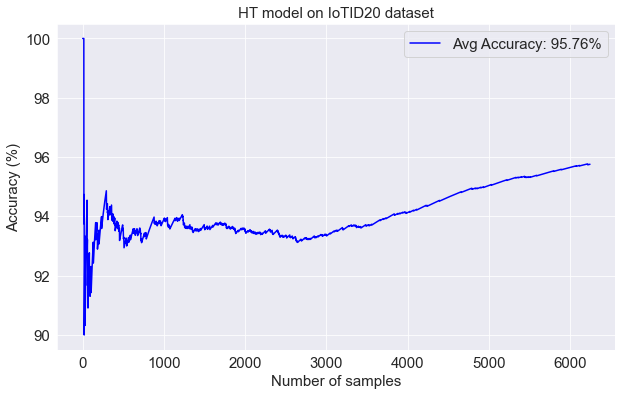

In [51]:
%%time
# Use the Hoeffding Tree (HT) model 
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier() # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 97.82300000000001%
Precision: 98.63%
Recall: 99.065%
F1-score: 98.847%
Wall time: 18.9 s


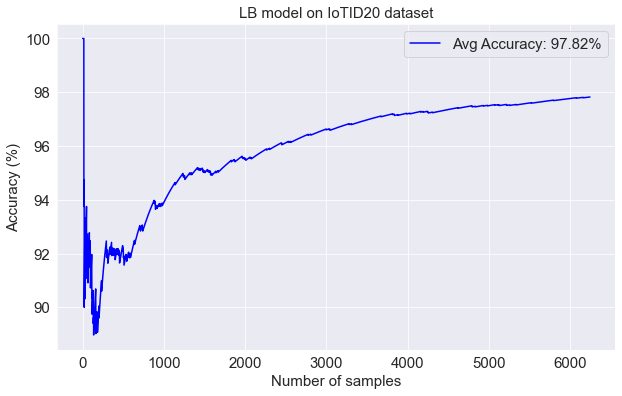

In [52]:
%%time
# Use the Leveraging Bagging (LB) model 
name2 = "LB model"
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 97.342%
Precision: 97.587%
Recall: 99.643%
F1-score: 98.604%
Wall time: 4.03 s


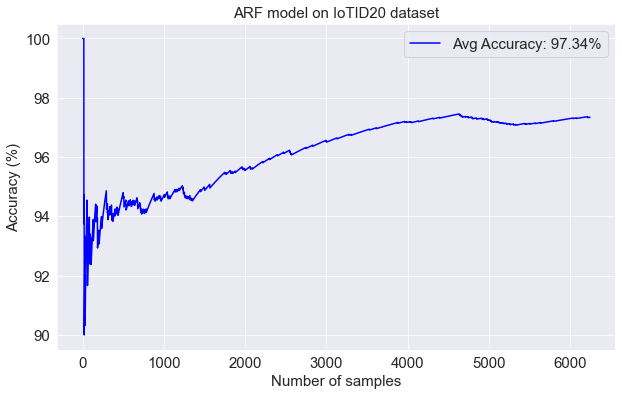

In [53]:
%%time
# Use the Adaptive Random Forest (ARF) model
name3 = "ARF model"
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.735%
Precision: 99.203%
Recall: 99.456%
F1-score: 99.33%
Wall time: 12.9 s


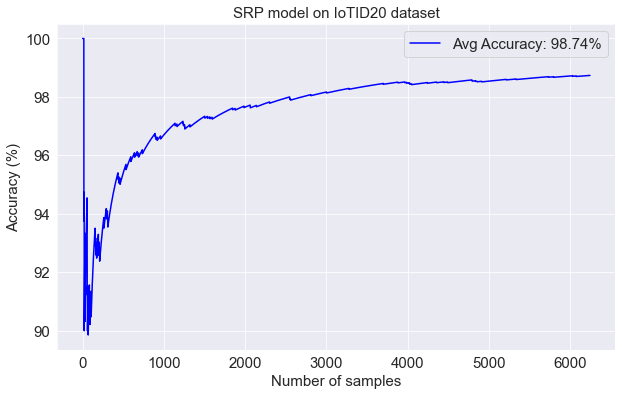

In [54]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP model"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

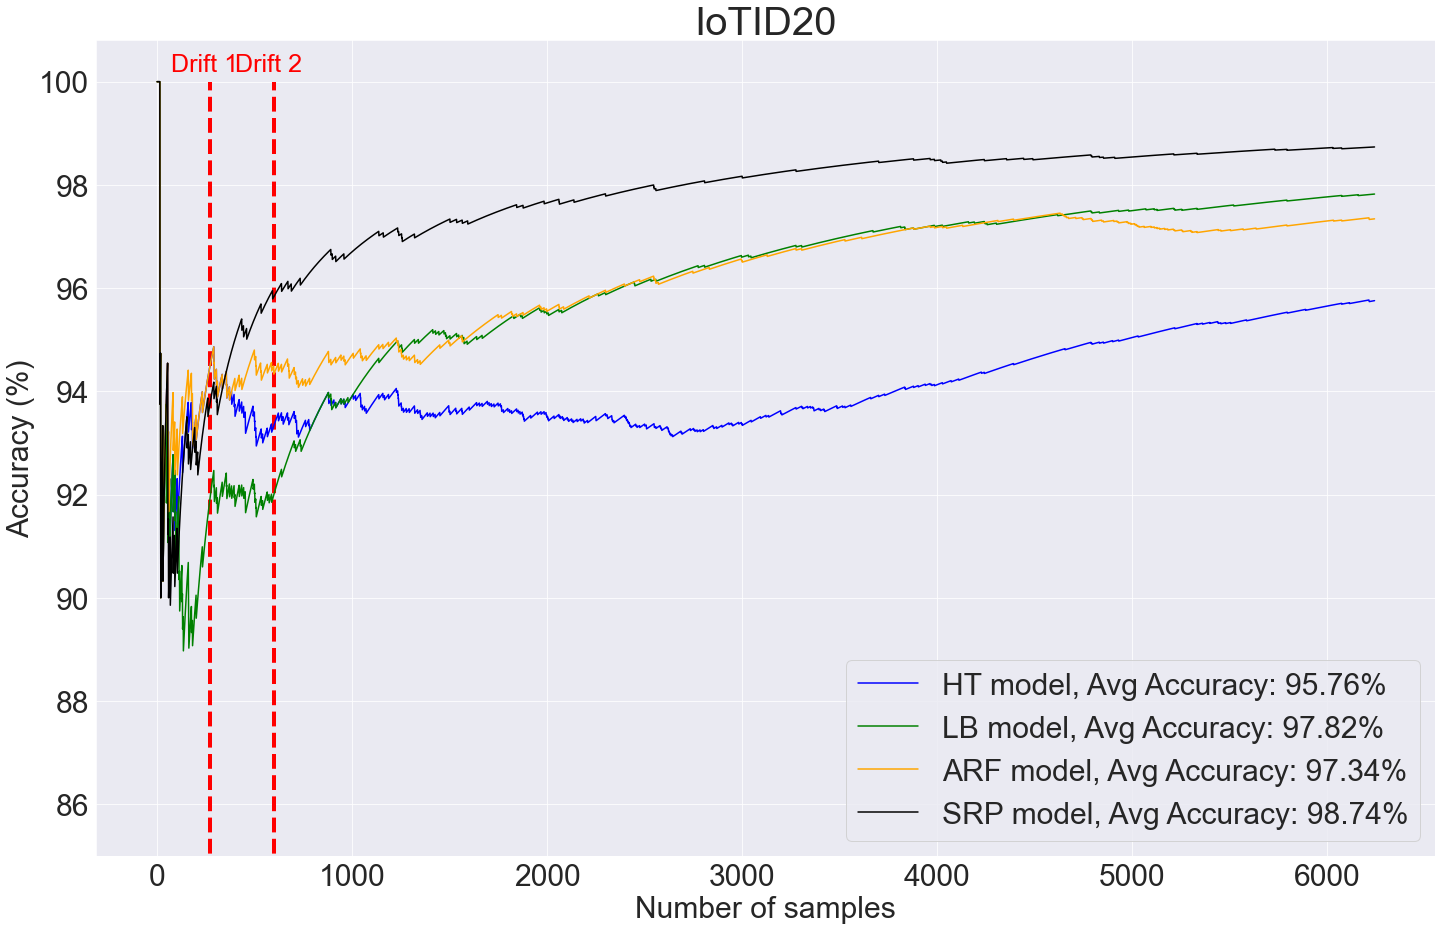

In [55]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))

# Draw the drift points/time
dr = [0,270,600]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-200, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(85, 100.8)
plt.title('IoTID20', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

## Automated Online Learning Model Selection

Select the best-performing model among four state-of-the-art online learning models (HT, LB, ARF, and SRP) by evaluating their learning performance

In [47]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    ypb = [] # record all the predicted labels of the test set for the best performing model
    acc_b = 0 # The best accuracy score
    mb = [] # record the real-time accuracy of the best performing model
    
    for model in model_list:
        # Learn the training set
        for xi1, yi1 in stream.iter_pandas(X_train, y_train):
            model.learn_one(xi1,yi1) 

        # Predict the test set
        for xi, yi in stream.iter_pandas(X_test, y_test):
            y_pred= model.predict_one(xi)  # Predict the test sample
            model.learn_one(xi,yi) # Learn the test sample
            metric = metric.update(yi, y_pred) # Update the real-time accuracy
            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred)
            i = i+1
#         print(accuracy_score(yt,yp))
        if accuracy_score(yt,yp)>acc_b:
            acc_b = accuracy_score(yt,yp)
            mb = m
            ypb = yp
            model_b = model
            
    print(model_b)    
    print("Accuracy: "+str(round(accuracy_score(yt,ypb),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,ypb),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,ypb),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,ypb),5)*100)+"%")
    return t, mb

In [48]:
model1 = tree.HoeffdingTreeClassifier() 
model2 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3)
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3)
model4 = ensemble.SRPClassifier(n_models = 3)
model_list = [model1, model2, model3, model4]
t, mb = adaptive_learning_model_selection(model_list, X_train, y_train, X_test, y_test) # Learn the model on the dataset

SRPClassifier(HoeffdingTreeClassifier)
Accuracy: 97.787%
Precision: 98.092%
Recall: 99.588%
F1-score: 98.834%


SRP with the highest accuracy is selected as the best/most suitable online learner

# 4. Hyperparameter Optimization
Optimize the best performing online learning model (SRP) by tuning its hyperparameters

In [49]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the objective function
def objective(params):
    params = {
        'n_models': int(params['n_models']), 
        'subspace_size': abs(float(params['subspace_size'])),
    }
    clf = ensemble.SRPClassifier( **params)
    
    t, m = adaptive_learning(clf, X_train, y_train, X_test, y_test)
    
    return {'loss':-m[-1], 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_models': hp.quniform('n_models', 2, 10, 1),
    "subspace_size":hp.uniform('subspace_size', 0.3, 1),
}

# Detect the optimal hyperparameter values
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("SRP: Hyperopt estimated optimum {}".format(best))

Accuracy: 98.527%                                                                                                      
Precision: 99.285%                                                                                                     
Recall: 99.15%                                                                                                         
F1-score: 99.21799999999999%                                                                                           
Accuracy: 98.735%                                                                                                      
Precision: 99.187%                                                                                                     
Recall: 99.473%                                                                                                        
F1-score: 99.33%                                                                                                       
Accuracy: 99.119%                       

After hyperparameter optimization, the accuracy of SRP has been improved from 97.787% to 99.119%